In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torchvision.datasets import CIFAR10

## Dataset

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob
import os
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image

In [41]:
lr = 0.001
batch_size = 16
beta1 = 0
beta2 = 0.99
criterion = nn.BCELoss()
c_lambda = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
# class CelebA(Dataset):
  
#   def __init__(self, root, transform=None):
#     self.files = glob.glob(os.path.join(root, "*.jpg"))
#     self.transform = transform

#   def __getitem__(self, index):

#     image = Image.open(self.files[index]) 

#     if self.transform is not None:
#       return self.transform(image)
    
#     return image

#   def __len__(self):
#     return len(self.files)

In [6]:
def loaderFunc(transform):
  train_loader = DataLoader(
    CIFAR10(root="/content", download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
  )

  return train_loader

In [7]:
def sample_data(image_size=4):
    
  transform = transforms.Compose([
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])


  loader = loaderFunc(transform)

  for img, label in loader:
      yield (img, label)

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/06/Tables-Showing-Generator-and-Discriminator-Configuration-for-the-Progressive-Growing-GAN.png"  width="1024"/>

In [8]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        # assuming input is in the from of (batch_size, channels, width, height)
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True)
                                  + 1e-8)

In [9]:
from math import sqrt 
def EqualLR(module, input):

  weight = getattr(module, 'weight')
  del module._parameters['weight']
  weight * sqrt(2 / (weight.size(1) * weight[0][0].numel()))
  module.register_parameter("weight", nn.Parameter(weight.data))
  return input

In [10]:
class EqualConv2d(nn.Module):
  
  def __init__(self, *args, **kwargs):
    
    super().__init__()

    self.conv = nn.Conv2d(*args, **kwargs)
    self.conv.register_forward_pre_hook(EqualLR)

  def forward(self, x):
    return self.conv(x)

In [11]:
def GeneratorBlock(in_channel, out_channel, output_size, first_block=False):
  # Growing gradually to 1024 * 1024 is done by incrementally adding blocks
  # in this function we get specification of the block and return it
  # for example input would be 4 * 4 and output_size would be 8 * 8
  if first_block:

    model = nn.Sequential(
      EqualConv2d(in_channel, out_channel, kernel_size=4, padding=3),
      nn.LeakyReLU(0.2),
      PixelNorm(),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),
    )
  else:

    model = nn.Sequential(
    
      nn.Upsample((output_size, output_size), mode='bilinear', align_corners=True),
      EqualConv2d(in_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),
    )

  return model  

In [12]:
class Generator(nn.Module):

  def __init__(self):
    
    super().__init__()

    self.block4_4 = GeneratorBlock(512, 512, 8, first_block=True)
    self.block8_8 = GeneratorBlock(512, 512, 8)
    self.block16_16 = GeneratorBlock(512, 512, 16)
    self.block32_32 = GeneratorBlock(512, 512, 32)
    self.block64_64 = GeneratorBlock(512, 256, 64)
    self.block128_128 = GeneratorBlock(256, 128, 128)

    self.blocks = nn.ModuleList([
        self.block4_4,
        self.block8_8,
        self.block16_16,
        self.block32_32,
        self.block64_64,
        self.block128_128
    ])

    self.to_rgbs = nn.ModuleList([
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(256, 3, 1),
      nn.Conv2d(128, 3, 1),
    ])


  def forward(self, x, step, alpha):
    # we have six steps toward progressively increase the output
    # alpha is the weight of output of new block compared to upsampled input
    if step == 1: # no need to average
      out = self.blocks[0](x)
      out = self.to_rgbs[0](out)

    elif step > 1:

      for block in self.blocks[:step - 2]: # assuming all previous blocks have been trained completely
        x = block(x)

      x_small_block = self.blocks[step-2](x) # 512 * 32 * 32
      x_small_image = self.to_rgbs[step-2](x_small_block) # 3 * 32 * 32

      x_large_block = self.blocks[step-1](x_small_block) # 256 * 64 * 64
      x_large_image = self.to_rgbs[step-1](x_large_block) # 3 * 64 * 64


      x_small_upsample = F.interpolate(x_small_image, x_large_image.shape[-2:]) # 3 * 64 * 64

      out = (alpha *  x_large_image) + (1 - alpha) * (x_small_upsample)


    return out


In [13]:
gen = Generator().to(device)

In [15]:
gen(torch.randn(16, 512, 1, 1).to(device), 4, 0.2).shape

torch.Size([16, 3, 32, 32])

In [16]:
def DiscriminatorBlock(in_channel, out_channel, output_size, last_block=False):
  # Growing gradually to 1024 * 1024 is done by incrementally adding blocks
  # in this function we get specification of the block and return it
  # for example input would be 4 * 4 and output_size would be 8 * 8
  if last_block:

    model = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),

      nn.Conv2d(out_channel, out_channel, kernel_size=4, padding=0),
      nn.LeakyReLU(0.2),
      nn.Flatten(start_dim=1),
      nn.Linear(512, 1),
    )
  else:

    model = nn.Sequential(
    
      EqualConv2d(in_channel, out_channel, kernel_size=3, padding=1),
      PixelNorm(),
      nn.LeakyReLU(0.2),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      PixelNorm(),
      nn.LeakyReLU(0.2),

      nn.AvgPool2d(kernel_size=2),
    )

  return model

In [17]:
class Discriminator(nn.Module):

  def __init__(self):
    
    super().__init__()

    self.block64_64 = DiscriminatorBlock(128, 256, 64)
    self.block32_32 = DiscriminatorBlock(256, 512, 32)
    self.blcok16_16 = DiscriminatorBlock(512, 512, 16)
    self.block8_8 = DiscriminatorBlock(512, 512, 8)
    self.block4_4 = DiscriminatorBlock(512, 512, 4)
    self.block1_1 = DiscriminatorBlock(512, 512, 1, last_block=True)

    self.blocks = nn.ModuleList([
      self.block64_64,
      self.block32_32,
      self.blcok16_16,
      self.block8_8,
      self.block4_4,
      self.block1_1
    ])

    self.from_rgbs = nn.ModuleList([
      nn.Conv2d(3, 128, 1),
      nn.Conv2d(3, 256, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
    ])
  

  def forward(self, x_large, step, alpha):
    
    if step == 1:
      out = self.from_rgbs[-step](x_large)
      out = self.blocks[-step](out)
    
    elif step > 1:
      
      x_large_feature_map = self.from_rgbs[(6-step)](x_large) # input : 3 * 8 * 8 and output is 512 * 8 * 8
      x_small = self.blocks[-step](x_large_feature_map) # last layer output is 512 * 4 * 4
      
      x_large_downsampled = F.avg_pool2d(self.from_rgbs[(6 - step) + 1](x_large), kernel_size=2) # input 3 * 8 * 8 => output is 512 * 8 * 8 => downsampled to 512 * 4 * 64

      out = (1 - alpha) * x_large_downsampled + (alpha * x_small)

      for block in self.blocks[(6 - step) + 1:]:
        out = block(out)
    
    return out

In [18]:
disc = Discriminator().to(device)

In [19]:
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr , betas=(beta1, beta2))
disc_optim = torch.optim.Adam(disc.parameters(), lr=lr , betas=(beta1, beta2))

In [20]:
from tqdm.auto import tqdm

In [39]:
def gradient_penalty(real, fake, epsilon, step, alpha):
  
  mixed_images = epsilon * real + (1 - epsilon) * fake
  mixed_scores = disc(mixed_images, step, alpha)

  gradients = torch.autograd.grad(
      outputs=mixed_scores,
      inputs=mixed_images,
      grad_outputs=torch.ones_like(mixed_scores),
      retain_graph=True,
      create_graph=True,
  )[0]

  flat_gradients = gradients.reshape(len(gradients), -1)

  norm = torch.norm(flat_gradients, dim=1)

  gp = torch.mean((norm - 1) ** 2)

  return gp

0it [00:00, ?it/s]

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


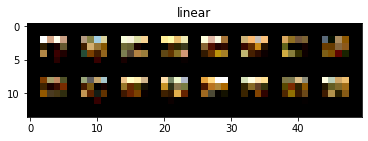

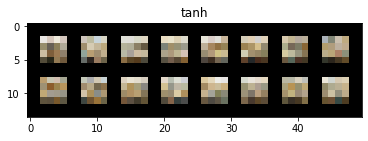

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


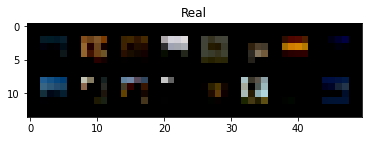

Gen Loss 64721052.0
Disc Loss 2.325654559478776e+18


KeyboardInterrupt: ignored

In [42]:
# step and alpha
step = 1
step_size = 0.001
alpha = 0
latent_space_size = 512

for iteration, (real, _) in enumerate(tqdm(sample_data(2 ** (step + 1)))):

  real = real.to(device)

  alpha += step_size

  if alpha == 1 and step < 4:
    step += 1
    alpha = 0

  # Training Generator
  gen_optim.zero_grad()

  fake = gen(torch.randn(batch_size, latent_space_size, 1, 1).to(device), step, alpha)
  pred_fake = disc(fake, step, alpha).reshape(-1)
  gen_loss = - torch.mean(pred_fake)

  gen_loss.backward()



  gen_optim.step()


  # Training Discriminator
  disc_optim.zero_grad()

  fake = gen(torch.randn(batch_size, latent_space_size, 1, 1).to(device), step, alpha).detach()
  pred_fake = disc(fake, step, alpha)

  pred_real = disc(real, step, alpha)

  epsilon = torch.randn(len(real), 1, 1, 1, requires_grad=True).to(device)
  gp = gradient_penalty(real, fake, epsilon, step, alpha)

  disc_loss = - torch.mean(pred_real - pred_fake) + (c_lambda * gp)

  disc_loss.backward()

  

  disc_optim.step()

  if iteration % 250 == 0:
    visualize(fake, "linear")
    visualize((torch.tanh(fake) + 1) / 2, "tanh")
    visualize(real, "Real")

    print("Gen Loss", gen_loss.item())
    print("Disc Loss", disc_loss.item())

In [23]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [24]:
def visualize(tensor, title):

  detached_tensor = tensor.cpu().detach()
  
  image_grid = make_grid(detached_tensor, nrow=8)
  
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.title(title)
  plt.show()